# Limpieza de texto
### Creación de los dataframe y limpieza de texto

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

In [2]:
import re
def general(txt: str, bert=False, nums=True) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))
        txt = re.sub(r'[^\w\s]', '', txt)

    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt

In [3]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador horizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [4]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [5]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

In [323]:
# limpiar titulos
def limpiar_palabras(text):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,4}|IX|X)[). -]|[^\w\s]',' ',text)
    #text = re.sub(r'(i{1,3}|iv|v|vi{1,4}|ix|x)[). -]|[^\w\s]','',text)
    text=text.lower()
    text = [
        i for i in text.split() if len(i) > 3
    ]
    return ' '.join(text)

#### Eliminar stopwords

In [320]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = limpiar_palabras(texto)
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return ' '.join(texto)

# Busqueda de titulos

## Títulos con números romanos y en mayúsculas

In [8]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


# Creacion de dataframe de solo titulos en mayusculas

In [133]:
# Creamos un dataframe para guardar expedientes que solamente tienen titulos en mayusculas
# Guardo en dfTitulosMayusculas los expedientes y su indice dentro del dataframe limpio (con todos los expedientes)
expConTitulosMayusculas = []
expSinTitulosEncontrados = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))
    else:
        expSinTitulosEncontrados.append((id,titulo))


dfTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['id','expediente'])
dfSinTitulosEncontrados = pd.DataFrame(expSinTitulosEncontrados, columns=['id','expediente'])
#pprint(dfTitulosMayusculas)

In [ ]:
pprint(dfSinTitulosEncontrados['expediente'][0])

In [134]:
dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(remove_stops)

# NUEVAS BUSQUEDAS
### Títulos con números latinos y romanos en mayúsculas. Escritos en mayusculas y minusculas.

In [288]:
# Busca títulos en mayusculas o minusculas comenzados con numeros latinos o romanos
def buscarTitulosLatinosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'((I{1,3}|IV|V|VI{1,3}|IX|X)|[0-9])[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())


    return titulosMayusculasEncontrados
# titulosLatinosMayusculas: lista que guarda los títulos encontrados
titulosLatinosMayusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    #if len(buscarTitulosLatinosMayusculas(expediente)) > 3:
    titulosLatinosMayusculas.append(buscarTitulosLatinosMayusculas(expediente))

In [289]:
titulosLatinosMayusculas[0]

['1) Antecedentes Medicos Legales Importancia.',
 '2) Examen Fisico.',
 '3) Examen Psiquico.',
 '4) Examenes complementarios.',
 '5) Consideraciones medico legales.',
 '6) Conclusiones medico legales.',
 '4.. Calculo Incapacidad Sobreviniente:',
 '7) Puntos pericia parte actora:',
 '6. Ver conclusiones medico legales.',
 '8) Puntos pericia parte demandada:',
 '6. Asi realizo.']

# Dataframe de títulos candidatos

In [246]:
# Encontrar la ubicacion del titulo en el documento
titulosCandidatos=[]
expSinTitulosEncontrados = dfSinTitulosEncontrados['expediente'].apply(str)
for i in range(len(expSinTitulosEncontrados)):
    for titulo in titulosLatinosMayusculas[i]:
        inicioTitulo = expSinTitulosEncontrados[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        titulosCandidatos.append((i,titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

dfTitulosCandidatos = pd.DataFrame(titulosCandidatos,columns=['id','titulo','inicio','fin','longitud'])

In [264]:
# Creamos un dataframe para guardar expedientes que no tienen ningun titulo candidato

# Guardo en dfSinTitulos los expedientes y su indice que no tienen titulos candidatos en el dataframe dfSinTitulosEncontrados
expSinTitulos=[]
for id,titulo in  enumerate(dfSinTitulosEncontrados['expediente']):
    if len(titulosLatinosMayusculas[id]) <= 0:
        expSinTitulos.append((id,titulo))

dfSinTitulos = pd.DataFrame(expSinTitulos, columns=['id','expediente'])

In [337]:
dfSinTitulos

,id,expediente
0,8,SE PRESENTA – HACE SABER: Juz T 5Sr. Juez: ROB...
1,11,PERITO MEDICO PRESENTA INFORME PERICIAL Juzgad...
2,12,PERITO MEDICO PRESENTA INFORME PERICIAL. Sr. J...
3,13,PERITO MEDICO INFORMA -SOLICITA EXPEDIENTE JUZ...
4,15,PERITO MEDICO PRESENTA PERICIA Sr. Juez: Susan...
...,...,...
719,2518,Juz T 4Sr. Juez: PERITO MEDICO SE PRESENTA – A...
720,2520,Perito Medico Legista responde intimacion Pres...
721,2525,PERITO MEDICO INFORMA . JUZGADO NACIONAL DEL T...
722,2528,-J. Trabajo 6PERITO MEDICA COMUNICA Señora jue...


In [338]:
pprint(dfSinTitulos.expediente[0])
pprint(df.text[14])

('SE PRESENTA – HACE SABER: Juz T 5Sr. Juez: ROBACIO JUAN CARLOS, perito '
 'medico, CUIT 20--2, e-mail , constituyendo domicilio legal calle Cabildo D '
 'ciudad Buenos Aires autos “AUGIER, JORGE OMAR C PROVINCIA ART S.A. S '
 'ACCIDENTE - LEY ESPECIAL”; Expte 17, presenta dice: Se informa cita AUGIER, '
 'JORGE OMAR , 09.3Hs, efectos realizar evaluacion misma consultorio calle Av. '
 'Cabildo 1 piso dto. “D” ciudad Buenos Aires. Proveer conformidad SERA '
 'JUSTICIA ROBACIO JUAN CARLOS Perito Medico M.N.')
('SE PRESENTA – HACE SABER: \n'
 '\n'
 'Juz T 51 \n'
 '\n'
 ' \n'
 '\n'
 'Sr. Juez: \n'
 '\n'
 'ROBACIO  JUAN  CARLOS,  perito  médico,  CUIT  Nº  20-04369960-2,  e-mail \n'
 '\n'
 'juancarobacio@yahoo.com, constituyendo domicilio legal en la calle Cabildo '
 '2327 \n'
 '\n'
 '1º  D  de  la  ciudad  de  Buenos  Aires  en  los  autos  “AUGIER,  JORGE  '
 'OMAR  C/ \n'
 '\n'
 'PROVINCIA  ART  S.A.  S/  ACCIDENTE  -  LEY  ESPECIAL”;  Expte  Nº \n'
 '\n'
 '25017/17, a V.S. se presenta 

# Expedientes con títulos candidatos y expedientes sin títulos localizados.

In [280]:
print(f'''
Cantidad de expediente que tienen titulos candidatos:        {len(dfSinTitulosEncontrados)}
Cantidad de expedientes que no tienen titulos localizados:    {len(dfSinTitulos)}  
Total de expedientes: {len(dfSinTitulosEncontrados)} ''')


Cantidad de expediente que tienen titulos candidatos:        2532
Cantidad de expedientes que no tienen titulos localizados:    724  
Total de expedientes: 2532 


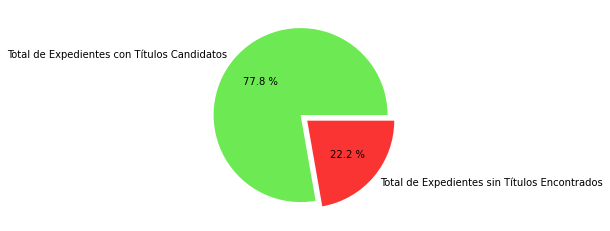

In [292]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfSinTitulosEncontrados)
totalExpSinEncontrar = len(dfSinTitulos)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpSinEncontrar]
nombreTitulos = ['Total de Expedientes con Títulos Candidatos', 'Total de Expedientes sin Títulos Encontrados']
colores = ['#6DEA53','#FA3333']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

### Títulos con números romanos en minusculas. Escritos en mayusculas y minusculas.

In [293]:
# Busca títulos en mayusculas o minusculas que comienzan con numeros romanos en minuscula.
def buscarTitulosRomanosMinusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(i{1,3}|iv|v|vi{1,3}|ix|x)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())
            #i=i+1

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosRomanosMinusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    if len(buscarTitulosRomanosMinusculas(expediente)) > 3:
        titulosRomanosMinusculas.append(buscarTitulosRomanosMinusculas(expediente))

In [12]:
dfTitulosMayusculas.to_excel('titulos_mayusculas.xlsx', index=False)

# Expedientes con titulos en mayusculas sobre el total de expedientes

In [242]:
print(f'''
Cantidad de expediente que tienen titulos en mayusculas:        {len(dfTitulosMayusculas)}
Cantidad de expedientes que no tienen titulos en mayusculas:    {len(dfLimpio) - len(dfTitulosMayusculas)}  
Total de expedientes: {len(dfLimpio)} ''')


Cantidad de expediente que tienen titulos en mayusculas:        1274
Cantidad de expedientes que no tienen titulos en mayusculas:    2532  
Total de expedientes: 3806 


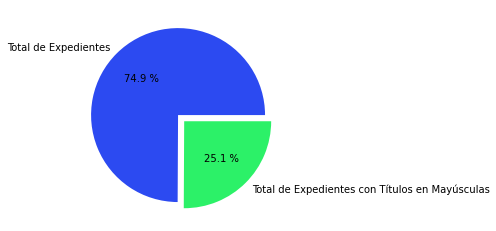

In [243]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfLimpio)
totalExpMayusculas = len(dfTitulosMayusculas)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpMayusculas]
nombreTitulos = ['Total de Expedientes', 'Total de Expedientes con Títulos en Mayúsculas']
colores = ['#2C4AF1','#2CF168']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

## Titulos y ubicacion

In [295]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion=[]

for titulo in titulosMayusculas[0]:
    inicioTitulo = dfLimpio[0].index(titulo)
    palabrasPorTitulo = len(titulo)
    finalTitulo = inicioTitulo + palabrasPorTitulo
    titulosPosicion.append((titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

pprint(titulosPosicion)

[('I-PROEMIO:', 161, 171, 10),
 ('II-ANTECEDENTES DE INTERES MEDICO-LEGAL:', 690, 730, 40),
 ('III-EXAMEN FISICO DEL ACTOR:', 1646, 1674, 28),
 ('IV-CONSIDERACIONES MEDICO-LEGALES:', 9140, 9174, 34),
 ('VII-CONCLUSIONES.', 19171, 19188, 17),
 ('VII-INCAPACIDAD:', 20974, 20990, 16),
 ('VIII CONTESTACION DE LOS PUNTOS DE PERICIA:', 21297, 21340, 43),
 ('IX-PETITORIO:', 21411, 21424, 13)]


In [322]:
# Creo una variable que contiene el párrafo de un título en particular
parrafoConsideraciones = dfLimpio[0][161:690]
#parrafoConsideraciones = general(parrafoConsideraciones)
parrafoConsideraciones = remove_stops(parrafoConsideraciones)
#parrafoConsideraciones = limpiar_palabras(parrafoConsideraciones)
pprint(parrafoConsideraciones)
pprint(f'LONGITUD DE PALABRAS: {len(parrafoConsideraciones.split())}')

('proemio juez nacional hortas maria andrea perito medico oficio siguientes '
 'autos domicilio constituido calle austria piso dpto capital domicilio '
 'electronico cumplimiento dispuesto referente presentes autos despues haber '
 'examinado dijo boiero franco ivan tomaron momento examen clinico actual '
 'consideraron capacidad generica particular puntos pericia solicitados partes')
'LONGITUD DE PALABRAS: 45'


# DATAFRAME DE UBICACIÓN DE TÍTULOS

In [17]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion1=[]

for i in range(len(dfLimpio)):
    for titulo in titulosMayusculas[i]:
        inicioTitulo = dfLimpio[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        titulosPosicion1.append((i,titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

dfUbicacionTitulos = pd.DataFrame(titulosPosicion1,columns=['id','titulo','inicio','fin','longitud'])

## Calculo de la longitud de los parrafos

In [326]:
# Calculo la longitud de caracteres de parrafos
def longitud_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['inicio'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['id'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                parrafo = remove_stops(parrafo)
                parrafo = general(parrafo)
               
                #parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                parrafo = general(parrafo)
                parrafo = remove_stops(parrafo)
                parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
    return parrafos

longitudP = longitud_parrafos(dfUbicacionTitulos, dfLimpio)

In [19]:
dfUbicacionTitulos['longitud_parrafo'] = pd.DataFrame(longitudP)

In [20]:
dfUbicacionTitulos['titulo'].to_csv('titulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_csv('df_TitulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_excel('df_TitulosEncontrados.xlsx',index=False)

In [283]:
dfTitulosCandidatos.to_csv('df_titulosCandidatos.csv',index=False)
dfTitulosCandidatos.to_excel('df_titulosCandidatos.xlsx', index=False)

In [78]:
dfUbicacionTitulos['longitud'].describe()

count    5776.000000
mean        2.252424
std         1.345312
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: longitud, dtype: float64

In [ ]:
#pprint(dfLimpio[1736][14170:])

In [328]:
# Creo una lista de parrafos
def extraer_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['fin'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['id'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split()
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split()
                parrafos.append(caracteres)
    return parrafos

parrafos = extraer_parrafos(dfUbicacionTitulos,dfLimpio)

In [329]:
print(f'LONGITUD DE PALABRAS: {len(parrafos[0])}')

LONGITUD DE PALABRAS: 44


In [24]:
#df['expediente'][165]

# CREACION DE DOCUMENTO HTML
## MUESTRO LOS TITULOS Y PARRAFOS ENCONTRADOS

In [25]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoConsideraciones = limpiarTextoHTML(parrafoConsideraciones)

In [26]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[1]}
        </p>
        <br>
        '''
body = body.replace(parrafoConsideraciones,f'<span style="background-color: #99ccff">{parrafoConsideraciones}</span>')
for titulo in titulosMayusculas[1]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)

# Gráfico de frecuencia de palabras por párrafo. BoxPlot.

# TF-IDF

In [31]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [32]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

In [33]:

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [34]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in titulosTfIdf:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [35]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 124979 items in vocab_frame


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,
                                 use_idf=True, ngram_range=(1,5))# tokenizer=tokenize_and_stem

tfidf_matrix = tfidf_vectorizer.fit_transform(dfTitulosMayusculas['expediente']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(1274, 1670)


In [37]:
terms = tfidf_vectorizer.get_feature_names()

In [ ]:
terms

## CountVectorizer

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(titulosMayusculasLower.split())
count_array = count_matrix.toarray()


In [ ]:
coun_vect.get_feature_names()

In [335]:
dfUbicacionTitulos

,id,titulo,inicio,fin,longitud,longitud_parrafo
0,0,proemio,161,171,1,45.0
1,0,antecedentes interes medico legal,690,730,4,75.0
2,0,examen fisico actor,1646,1674,3,612.0
3,0,consideraciones medico legales,9140,9174,3,800.0
4,0,conclusiones,19171,19188,1,129.0
...,...,...,...,...,...,...
5771,3801,,22588,22608,0,0.0
5772,3803,historia clinica,0,22,2,324.0
5773,3803,estudios solicitados,3860,3887,2,39.0
5774,3803,puntos periciales,4309,4332,2,20.0


# PRUEBA DE TF-IDF

In [ ]:
# Se unen los dos dataframes en uno solo
dfTitulos = pd.concat([dfUbicacionTitulos, dfTitulosCandidatos], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
dfTitulos = dfTitulos[['id', 'titulo', 'inicio', 'fin', 'longitud']]
dfTitulos.columns = ['id', 'titulo', 'inicio', 'fin', 'longitud']